In [1]:
import flwr as fl
import pydicom, re
import tensorflow as tf
import pandas as pd
import numpy as np
import flwr as fl
from os import listdir
from os.path import isfile, join, exists

In [2]:
class MRIDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col, batch_size,
                 input_size= (256, 256), depth_size=64,
                 shuffle=True):
 
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.depth_size = depth_size
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.n = len(self.df)
 
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
 
    def __get_input(self, path, target_size):
        scan3d = None
        onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
        filepatt = 'Image-{}.dcm'
        digits = [int(re.search('\d+',i).group()) for i in listdir(path) if re.match(filepatt.format('\d+\\'),i)]
        digits.sort()
        onlyfiles = [filepatt.format(dig) for dig in digits]
        
        center = len(onlyfiles) // 2
        left = max(0, center - (self.depth_size // 2))
        right = min(len(onlyfiles), center + (self.depth_size // 2))
        onlyfiles = onlyfiles[left: right]
        if len(onlyfiles) < self.depth_size:
            img_shape = pydicom.read_file(f'{path}{onlyfiles[0]}').pixel_array.shape
            add_z = self.depth_size - len(onlyfiles)
            scan3d = np.zeros((add_z, target_size[0], target_size[1],1))
        
            
        scans = []
        for f in onlyfiles:
            img = pydicom.read_file(f'{path}{f}')
            img = img.pixel_array
            img = self._rescale(img)
            img = np.expand_dims(img, axis=-1)
            img = tf.image.resize(img,(target_size[0], target_size[1])).numpy()
            
            img = self._normalize(img)
            scans.append(img)
        
        if scan3d is not None:
            return np.concatenate([np.array(scans), scan3d]) 
        else:
            return np.array(scans)
    def _rescale(self, arr):
        arr_min = arr.min()
        arr_max = arr.max()
        if (arr_max - arr_min) == 0:
            return arr
        return (arr - arr_min) / (arr_max - arr_min)
    def _normalize(self, arr):
        img = arr - arr.mean()
        # divide by the standard deviation (only if it is different from zero)
        if np.std(img) != 0:
            img = img / np.std(img)
        return img
    def __get_data(self, batches):
        if self.X_col is None:
            PATHS = ['FLAIR_path', 'T1w_path', 'T2w_path', 'T1wCE_path']
            X_batch = []
            for p in PATHS:
                batch_part_path = batches[p]
                X_batch.append(np.asarray([self.__get_input(x,  self.input_size) for x in batch_part_path]))
            y_batch = batches[self.y_col].values
            X_batch = np.concatenate(X_batch, axis=4)
            
        else:
            path_batch = batches[self.X_col]
            X_batch = np.asarray([self.__get_input(x,  self.input_size) for x in path_batch])
            y_batch = batches[self.y_col].values
        return X_batch, y_batch
    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        return X, y
    def __len__(self):
        return self.n // self.batch_size 

In [3]:
def checkDirectoryForExistence(dirName):
    return exists(f'./server_val_data/{str(dirName).zfill(5)}')

def getAllExistingDirs():
    return f'./server_val_data/' + test_df[test_df['BraTS21ID'].apply(checkDirectoryForExistence)]['BraTS21ID'].astype(str).str.zfill(5)

test_df = pd.read_csv(f"./train_labels.csv")
test_df['FLAIR_path'] = getAllExistingDirs() + '/FLAIR/'
test_df['T1w_path'] = getAllExistingDirs() + '/T1w/' 
test_df['T2w_path'] = getAllExistingDirs() + '/T2w/' 
test_df['T1wCE_path'] = getAllExistingDirs() + '/t1wCE/'
test_df = test_df.dropna(how='any')

In [4]:
depth = 64
resolution = (192, 192)
batches = 4

val_loss = []
val_acc = []

def get_eval_fn(model):
    """Return an evaluation function for server-side evaluation."""

    # The `evaluate` function will be called after every round
    def evaluate(weights: fl.common.Weights):
        model.set_weights(weights)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(MRIDataGenerator(test_df, 'FLAIR_path', 'MGMT_value', batches, resolution, depth, True))
        val_loss.append(loss)
        val_acc.append(accuracy)
        return loss, {"accuracy": accuracy}

    return evaluate

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64,192, 192, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
        optimizer='adam', 
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

In [6]:
strategy = fl.server.strategy.FedAvg(
    # ... other FedAvg agruments
    fraction_eval=1,
    min_eval_clients=3,
    min_available_clients=3,
    fraction_fit=1,
    min_fit_clients=3,
    eval_fn=get_eval_fn(model)
)

In [7]:
fl.server.start_server(config={"num_rounds": 10}, strategy=strategy)

INFO flower 2022-05-27 00:59:31,719 | app.py:134 | Flower server running (10 rounds), SSL is disabled
INFO flower 2022-05-27 00:59:31,721 | server.py:84 | Initializing global parameters
INFO flower 2022-05-27 00:59:31,722 | server.py:256 | Requesting initial parameters from one random client
INFO flower 2022-05-27 00:59:38,818 | server.py:259 | Received initial parameters from one random client
INFO flower 2022-05-27 00:59:38,819 | server.py:86 | Evaluating initial parameters


20/20 [==============================] - 94s 5s/step - loss: 1.3706 - binary_accuracy: 0.4500


INFO flower 2022-05-27 01:01:20,933 | server.py:89 | initial parameters (loss, other metrics): 1.3706250190734863, {'accuracy': 0.44999998807907104}
INFO flower 2022-05-27 01:01:20,933 | server.py:99 | FL starting
DEBUG flower 2022-05-27 01:01:20,934 | server.py:203 | fit_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 01:15:23,632 | server.py:216 | fit_round received 3 results and 0 failures
WARNING flower 2022-05-27 01:15:23,880 | fedavg.py:237 | No fit_metrics_aggregation_fn provided


20/20 [==============================] - 94s 5s/step - loss: 0.6895 - binary_accuracy: 0.4875


INFO flower 2022-05-27 01:17:05,027 | server.py:114 | fit progress: (1, 0.6895262002944946, {'accuracy': 0.48750001192092896}, 943.9813736)
DEBUG flower 2022-05-27 01:17:05,027 | server.py:157 | evaluate_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 01:19:02,076 | server.py:170 | evaluate_round received 3 results and 0 failures
WARNING flower 2022-05-27 01:19:02,077 | fedavg.py:268 | No evaluate_metrics_aggregation_fn provided
DEBUG flower 2022-05-27 01:19:02,078 | server.py:203 | fit_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 01:32:56,783 | server.py:216 | fit_round received 3 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.6939 - binary_accuracy: 0.4625


INFO flower 2022-05-27 01:34:38,248 | server.py:114 | fit progress: (2, 0.693936824798584, {'accuracy': 0.4625000059604645}, 1997.1344268999999)
DEBUG flower 2022-05-27 01:34:38,248 | server.py:157 | evaluate_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 01:36:35,314 | server.py:170 | evaluate_round received 3 results and 0 failures
DEBUG flower 2022-05-27 01:36:35,315 | server.py:203 | fit_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 01:50:31,279 | server.py:216 | fit_round received 3 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.6944 - binary_accuracy: 0.5000


INFO flower 2022-05-27 01:52:12,564 | server.py:114 | fit progress: (3, 0.6943678259849548, {'accuracy': 0.5}, 3051.3132335)
DEBUG flower 2022-05-27 01:52:12,572 | server.py:157 | evaluate_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 01:54:09,493 | server.py:170 | evaluate_round received 3 results and 0 failures
DEBUG flower 2022-05-27 01:54:09,494 | server.py:203 | fit_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 02:08:07,989 | server.py:216 | fit_round received 3 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.7416 - binary_accuracy: 0.4500


INFO flower 2022-05-27 02:09:49,526 | server.py:114 | fit progress: (4, 0.7416276931762695, {'accuracy': 0.44999998807907104}, 4108.223994700001)
DEBUG flower 2022-05-27 02:09:49,528 | server.py:157 | evaluate_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 02:11:46,575 | server.py:170 | evaluate_round received 3 results and 0 failures
DEBUG flower 2022-05-27 02:11:46,575 | server.py:203 | fit_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 02:25:43,474 | server.py:216 | fit_round received 3 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.6947 - binary_accuracy: 0.4750


INFO flower 2022-05-27 02:27:24,899 | server.py:114 | fit progress: (5, 0.6947404146194458, {'accuracy': 0.4749999940395355}, 5163.4639683000005)
DEBUG flower 2022-05-27 02:27:24,914 | server.py:157 | evaluate_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 02:29:24,155 | server.py:170 | evaluate_round received 3 results and 0 failures
DEBUG flower 2022-05-27 02:29:24,156 | server.py:203 | fit_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 02:43:22,005 | server.py:216 | fit_round received 3 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.7117 - binary_accuracy: 0.5000


INFO flower 2022-05-27 02:45:03,242 | server.py:114 | fit progress: (6, 0.7117251753807068, {'accuracy': 0.5}, 6221.691986100001)
DEBUG flower 2022-05-27 02:45:03,242 | server.py:157 | evaluate_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 02:47:00,274 | server.py:170 | evaluate_round received 3 results and 0 failures
DEBUG flower 2022-05-27 02:47:00,275 | server.py:203 | fit_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 03:00:56,470 | server.py:216 | fit_round received 3 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.7268 - binary_accuracy: 0.5125


INFO flower 2022-05-27 03:02:37,778 | server.py:114 | fit progress: (7, 0.7267957925796509, {'accuracy': 0.512499988079071}, 7276.1562112)
DEBUG flower 2022-05-27 03:02:37,793 | server.py:157 | evaluate_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 03:04:34,917 | server.py:170 | evaluate_round received 3 results and 0 failures
DEBUG flower 2022-05-27 03:04:34,917 | server.py:203 | fit_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 03:18:30,934 | server.py:216 | fit_round received 3 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.7363 - binary_accuracy: 0.4375


INFO flower 2022-05-27 03:20:12,236 | server.py:114 | fit progress: (8, 0.7363268136978149, {'accuracy': 0.4375}, 8330.4712394)
DEBUG flower 2022-05-27 03:20:12,236 | server.py:157 | evaluate_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 03:22:09,710 | server.py:170 | evaluate_round received 3 results and 0 failures
DEBUG flower 2022-05-27 03:22:09,710 | server.py:203 | fit_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 03:36:09,169 | server.py:216 | fit_round received 3 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.7098 - binary_accuracy: 0.4875


INFO flower 2022-05-27 03:37:50,546 | server.py:114 | fit progress: (9, 0.7098262310028076, {'accuracy': 0.48750001192092896}, 9388.722397099998)
DEBUG flower 2022-05-27 03:37:50,546 | server.py:157 | evaluate_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 03:39:47,347 | server.py:170 | evaluate_round received 3 results and 0 failures
DEBUG flower 2022-05-27 03:39:47,347 | server.py:203 | fit_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 03:53:33,706 | server.py:216 | fit_round received 3 results and 0 failures


20/20 [==============================] - 94s 5s/step - loss: 0.7189 - binary_accuracy: 0.4875


INFO flower 2022-05-27 03:55:15,410 | server.py:114 | fit progress: (10, 0.7188926339149475, {'accuracy': 0.48750001192092896}, 10433.4475449)
DEBUG flower 2022-05-27 03:55:15,410 | server.py:157 | evaluate_round: strategy sampled 3 clients (out of 3)
DEBUG flower 2022-05-27 03:57:12,484 | server.py:170 | evaluate_round received 3 results and 0 failures
INFO flower 2022-05-27 03:57:12,484 | server.py:138 | FL finished in 10550.5140273
INFO flower 2022-05-27 03:57:12,491 | app.py:178 | app_fit: losses_distributed [(1, 0.7197377934600367), (2, 0.6938055398488285), (3, 0.6910632180445122), (4, 0.6858191514256025), (5, 0.6894267062948207), (6, 0.7068088367731884), (7, 0.7507071380663399), (8, 0.7087630533208751), (9, 0.7102926981569541), (10, 0.7320373576096814)]
INFO flower 2022-05-27 03:57:12,491 | app.py:179 | app_fit: metrics_distributed {}
INFO flower 2022-05-27 03:57:12,491 | app.py:180 | app_fit: losses_centralized [(0, 1.3706250190734863), (1, 0.6895262002944946), (2, 0.69393682479

History (loss, distributed):
	round 1: 0.7197377934600367
	round 2: 0.6938055398488285
	round 3: 0.6910632180445122
	round 4: 0.6858191514256025
	round 5: 0.6894267062948207
	round 6: 0.7068088367731884
	round 7: 0.7507071380663399
	round 8: 0.7087630533208751
	round 9: 0.7102926981569541
	round 10: 0.7320373576096814
History (loss, centralized):
	round 0: 1.3706250190734863
	round 1: 0.6895262002944946
	round 2: 0.693936824798584
	round 3: 0.6943678259849548
	round 4: 0.7416276931762695
	round 5: 0.6947404146194458
	round 6: 0.7117251753807068
	round 7: 0.7267957925796509
	round 8: 0.7363268136978149
	round 9: 0.7098262310028076
	round 10: 0.7188926339149475
History (metrics, centralized):
{'accuracy': [(0, 0.44999998807907104), (1, 0.48750001192092896), (2, 0.4625000059604645), (3, 0.5), (4, 0.44999998807907104), (5, 0.4749999940395355), (6, 0.5), (7, 0.512499988079071), (8, 0.4375), (9, 0.48750001192092896), (10, 0.48750001192092896)]}

In [1]:
loss_distributed = [0.7197377934600367, 0.6938055398488285, 0.6910632180445122, 0.6858191514256025, 0.6894267062948207, 0.7068088367731884, 0.7507071380663399, 0.7087630533208751, 0.7102926981569541, 0.7320373576096814]
loss_centralized = [1.3706250190734863, 0.6895262002944946, 0.693936824798584, 0.6943678259849548, 0.7416276931762695, 0.6947404146194458, 0.7117251753807068, 0.7267957925796509, 0.7363268136978149, 0.7098262310028076, 0.7188926339149475]

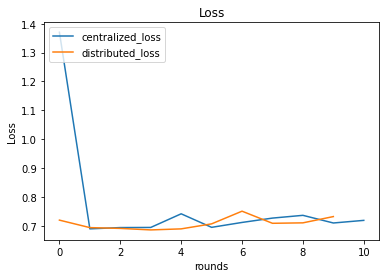

In [5]:
import matplotlib.pyplot as plt
plt.plot(loss_centralized)
plt.plot(loss_distributed)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('rounds')
plt.legend(['centralized_loss', 'distributed_loss'], loc='upper left')
plt.show()